In [81]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Set random seed
seed = 42

In [82]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [83]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 17425 non-null  int64  
 1   budget                17425 non-null  int64  
 2   genres                17410 non-null  object 
 3   original_language     17425 non-null  object 
 4   overview              17425 non-null  object 
 5   popularity            17425 non-null  float64
 6   production_companies  16811 non-null  object 
 7   production_countries  17253 non-null  object 
 8   revenue               17425 non-null  int64  
 9   runtime               17425 non-null  float64
 10  spoken_languages      17376 non-null  object 
 11  status                17425 non-null  object 
 12  tagline               17425 non-null  object 
 13  video                 17425 non-null  int64  
 14  vote_average          17425 non-null  float64
 15  vote_count         

# Score prediction

In [84]:
X = df.drop(columns=['vote_average', 'category'])
# Drop text columns
# X = X.drop(columns=['belongs_to_collection', 'tagline', 'overview'])
Y = df['category']


In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  13940
Test set size:  3485


# Feature encoding

In [86]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 17425 non-null  int64  
 1   budget                17425 non-null  int64  
 2   genres                17410 non-null  object 
 3   original_language     17425 non-null  object 
 4   overview              17425 non-null  object 
 5   popularity            17425 non-null  float64
 6   production_companies  16811 non-null  object 
 7   production_countries  17253 non-null  object 
 8   revenue               17425 non-null  int64  
 9   runtime               17425 non-null  float64
 10  spoken_languages      17376 non-null  object 
 11  status                17425 non-null  object 
 12  tagline               17425 non-null  object 
 13  video                 17425 non-null  int64  
 14  vote_count            17425 non-null  float64
 15  cast               

In [87]:
print(X.head())

   adult  budget         genres original_language  \
0      0       0  Drama,Western                en   
1      0       0    Documentary                fr   
2      0       0        History                it   
3      0       0          Drama                en   
4      0       0        Western                en   

                                            overview  popularity  \
0  A fiercely independent cowboy arranges to have...       8.262   
1  Documents the lives of infamous fakers Elmyr d...       7.830   
2  While on holiday in Rhodes, Athenian war hero ...       9.668   
3  In early 1960s London, barrister Melville Farr...       5.896   
4  Respected black cavalry Sergeant Brax Rutledge...       6.003   

                                production_companies  \
0                                   Joel Productions   
1                                   SACI,Janus Films   
2  Produzioni Atlas Consorziate,Procusa,Comptoir ...   
3                                               

In [88]:
# Define numerical, categorical, boolean, and text features
from sklearn.pipeline import FunctionTransformer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month', 'release_day']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

list_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(list_to_str, validate=False)),
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','), max_features=100))  # Adjust max_features as needed
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', list_transformer, 'genres'),
        ('production_companies', list_transformer, 'production_companies'),
        ('production_countries', list_transformer, 'production_countries'),
        ('cast', list_transformer, 'cast'),
        ('directors', list_transformer, 'directors')
    ]
)



# Opaque models

## SVM

In [89]:
clf = svm.SVC(gamma='auto')

# Define your pipeline with preprocessor
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', clf)
])

svm_pipeline.fit(X_train, Y_train_encoded)
Y_pred = svm_pipeline.predict(X_test)

# Convert predicted labels back to original categories
Y_pred_labels = label_encoder.inverse_transform(Y_pred)

accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

# Optionally: Check predicted labels
print("Predicted labels:", Y_pred_labels)

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy:  0.48149210903873746
Predicted labels: ['good' 'good' 'good' ... 'mediocre' 'good' 'good']


In [92]:
# Optionally: Check predicted labels
print("Predicted labels:", Y_pred_labels)

Predicted labels: ['good' 'good' 'good' ... 'mediocre' 'good' 'good']


In [93]:
print(Y_test.value_counts())

category
good        1393
mediocre    1095
great        614
bad          383
Name: count, dtype: int64


In [95]:
print(Y_train.value_counts())

category
good        5671
mediocre    4312
great       2546
bad         1411
Name: count, dtype: int64


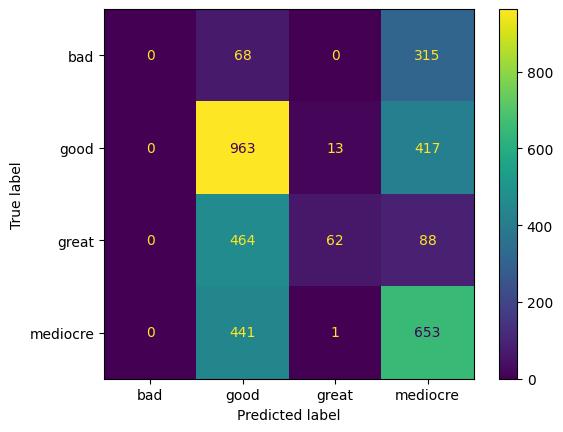

In [94]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()